In [1]:
%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit import *
from qiskit.visualization import *
# Loading your IBM Q account(s)
provider = IBMQ.load_account()

import numpy as np

from qiskit.providers.aer.noise import NoiseModel
from qiskit.aqua import QuantumInstance
from qiskit.providers.aer.noise import thermal_relaxation_error, ReadoutError, depolarizing_error

provider = IBMQ.get_provider(hub='ibm-q')
machine = provider.get_backend('ibmq_armonk')
from qiskit.test.mock import FakeLondon
machine_fake = FakeLondon()
machine_noise_model = NoiseModel.from_backend(machine)
simulator = Aer.get_backend('qasm_simulator')


C:\Users\Eesh Gupta\anacondaaa\lib\site-packages\qiskit\providers\ibmq\ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


In [2]:
machine_fake.properties().qubit_property(0, 'prob_meas1_prep0')[0]

0.01

In [3]:
machine_fake.properties().qubit_property(0, 'prob_meas0_prep1')[0]

0.050000000000000044

In [4]:
print(machine_fake.properties())

## Generate RB Circuits

In [5]:
#Import general libraries (needed for functions)
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

#Import the RB Functions
import qiskit.ignis.verification.randomized_benchmarking as rb

#Import Qiskit classes 
import qiskit
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors.standard_errors import depolarizing_error, thermal_relaxation_error

In [6]:
#Generate RB circuits (2Q RB)

#number of qubits
nQ=1
rb_opts = {}
#Number of Cliffords in the sequence
rb_opts['length_vector'] = [1] +[10*i for i in range(1, 16)]
#Number of seeds (random sequences)
rb_opts['nseeds'] =1
#Default pattern
rb_opts['rb_pattern'] = [[0]]

rb_circs, xdata = rb.randomized_benchmarking_seq(**rb_opts)

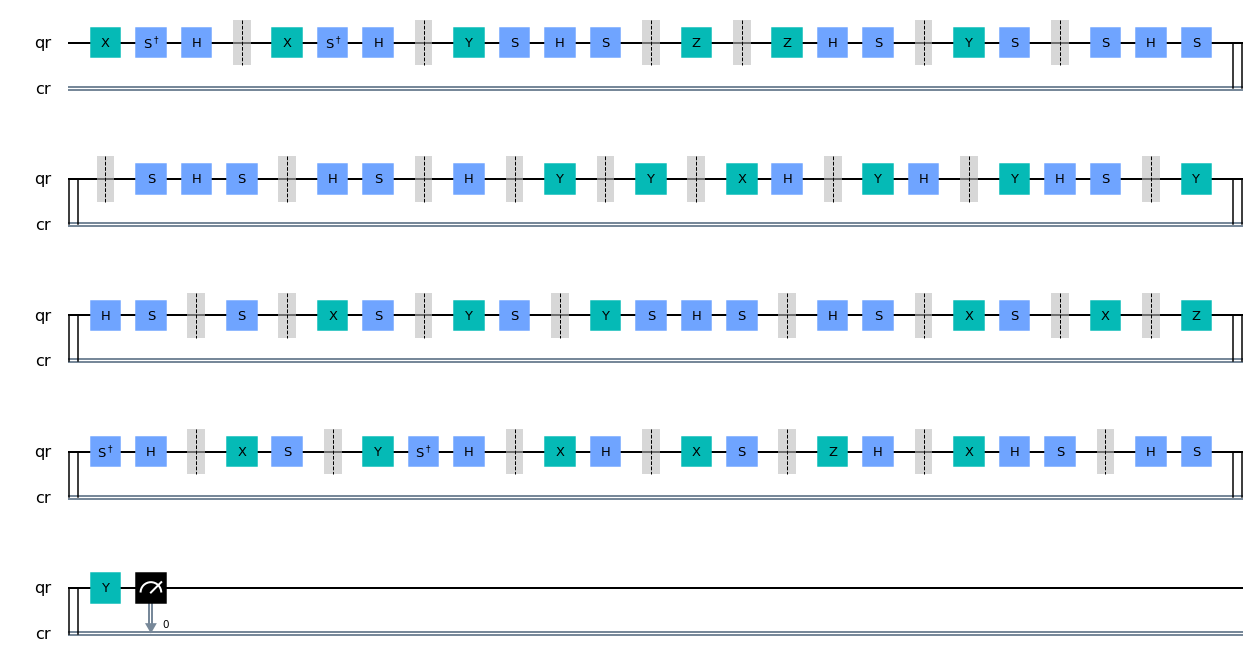

In [7]:
rb_circs[0][3].draw(output = 'mpl')

In [8]:
# converting everything to u3

from qiskit.compiler import transpile
basis_gates =  ['id', 'u3']

rb_u3_circs = []

for i in range(len(rb_circs)): 
    seed_circs = []
    for j in range(len(rb_circs[i])): 
        transpiled_circ = transpile(rb_circs[i][j], basis_gates = basis_gates)
        seed_circs.append(transpiled_circ)
    rb_u3_circs.append(seed_circs)

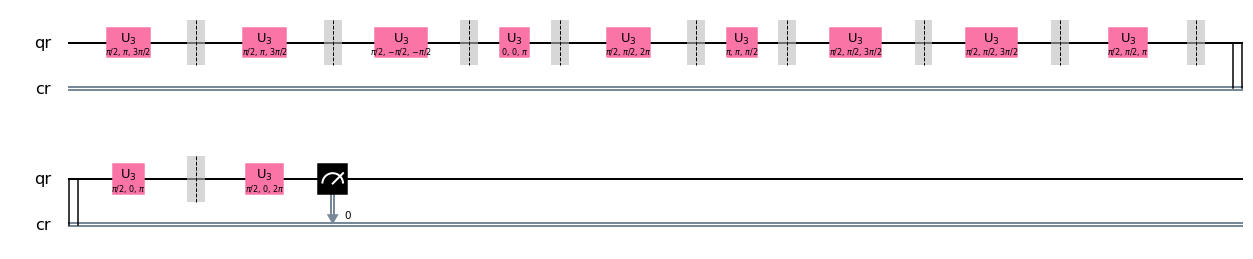

In [9]:
rb_u3_circs[0][1].draw(output = 'mpl')

## Now Scaling Schedules

In [10]:
from qiskit.scheduler import measure
from qiskit.pulse.instructions import Play, Acquire
from qiskit import pulse
from qiskit.pulse import Drag


def stretchSchedule(sched, factor):
    # args:circuit in pulse form WITHOUT measurement, stretch factor
    #output: pulses stretched by thefactor
    
    instrucs = sched.instructions
    new_sched = qiskit.pulse.Schedule(name = "Schedule stretched by factor " + str(factor))
    
    #Only stretching the sample pulse, doing nothing to shiftphase, measurement,etc.
    
    for instruc_paren in instrucs:
        instruc = instruc_paren[1]
        #if drag/gaussian square ....ignore gaussian, only add drag
        if (isinstance(instruc, Play)):
            
            #print(instruc)
            
            if (isinstance(instruc.pulse, Drag)):
                drag = instruc.pulse
                ## param = {"duration": self.duration, "amp": self.amp, "sigma": self.sigma, "width": self.width}
                param = drag.parameters
                #print("Initial Param")
                #print(param)
                #print("final Param")
                #print('Duration' + str(factor*param['duration']))

                #stretching the drag pulse
                s_pulse = Drag(int(factor*param['duration']), param['amp']/factor, factor*param['sigma'], param['beta'])
                channel = instruc.channels[0]
                new_sched+= pulse.Play(s_pulse, channel)
        
        #if not acquire    
        elif ( not isinstance(instruc, Acquire)):
            new_sched+= instruc
    
    #adding measurement
    new_sched +=measure([0], machine) <<new_sched.duration   #([0], backend)
    return new_sched

In [11]:
#circuits ----> scaled schedules

from qiskit.compiler import schedule 
from qiskit.compiler import transpile



scaled_schedules = []
scales = [1, 1.1, 1.2, 1.3]
for c in scales:
    scale_seeds = []
    for seed in rb_u3_circs: 
        new_seed =[]
        for circ in seed: 
            circ_device = transpile(circ, machine)
            sched_circ = schedule(circ_device, machine)
            scaled_sched =  stretchSchedule(sched_circ, c)
            new_seed.append(scaled_sched)
        scale_seeds.append(new_seed)
    scaled_schedules.append(scale_seeds)

C:\Users\Eesh Gupta\anacondaaa\lib\site-packages\ipykernel_launcher.py:42: DeprecationWarning: "measure" has been moved to "qiskit.pulse.macros"


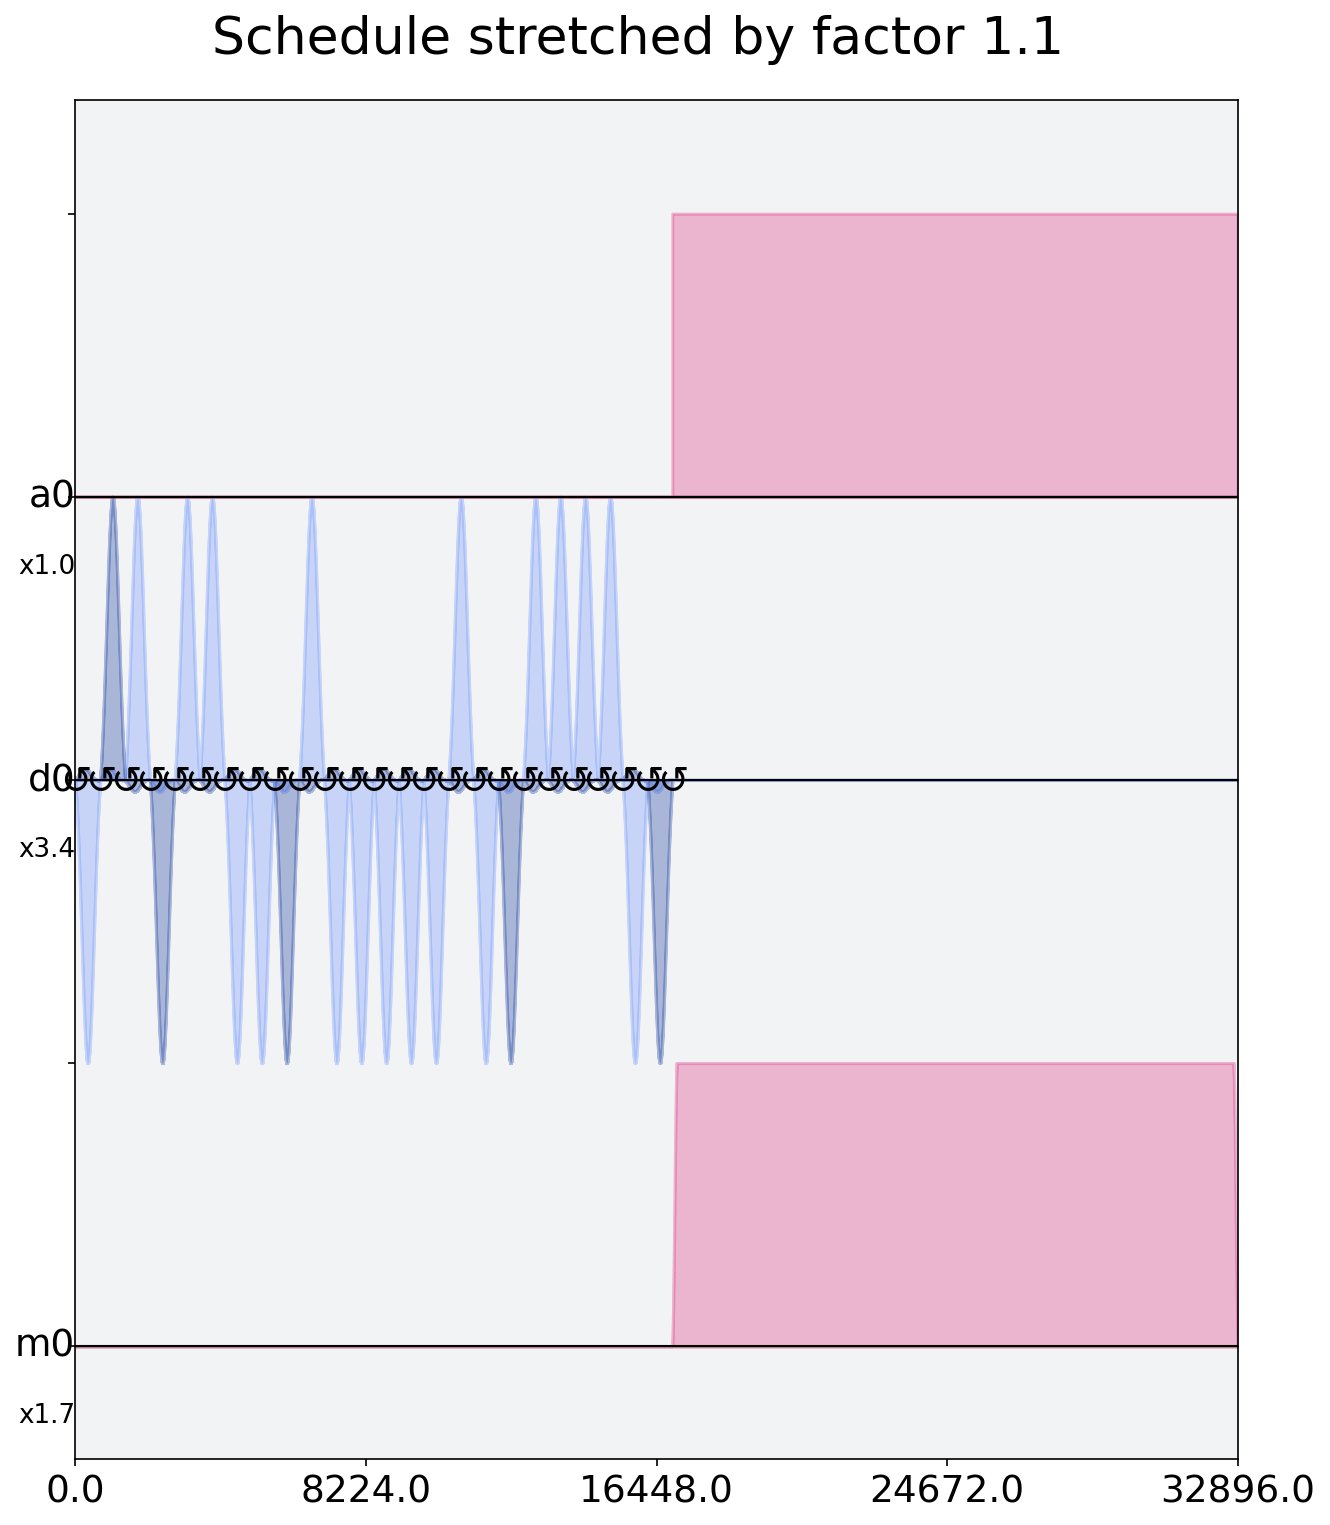

In [12]:
scaled_schedules[1][0][2].draw()

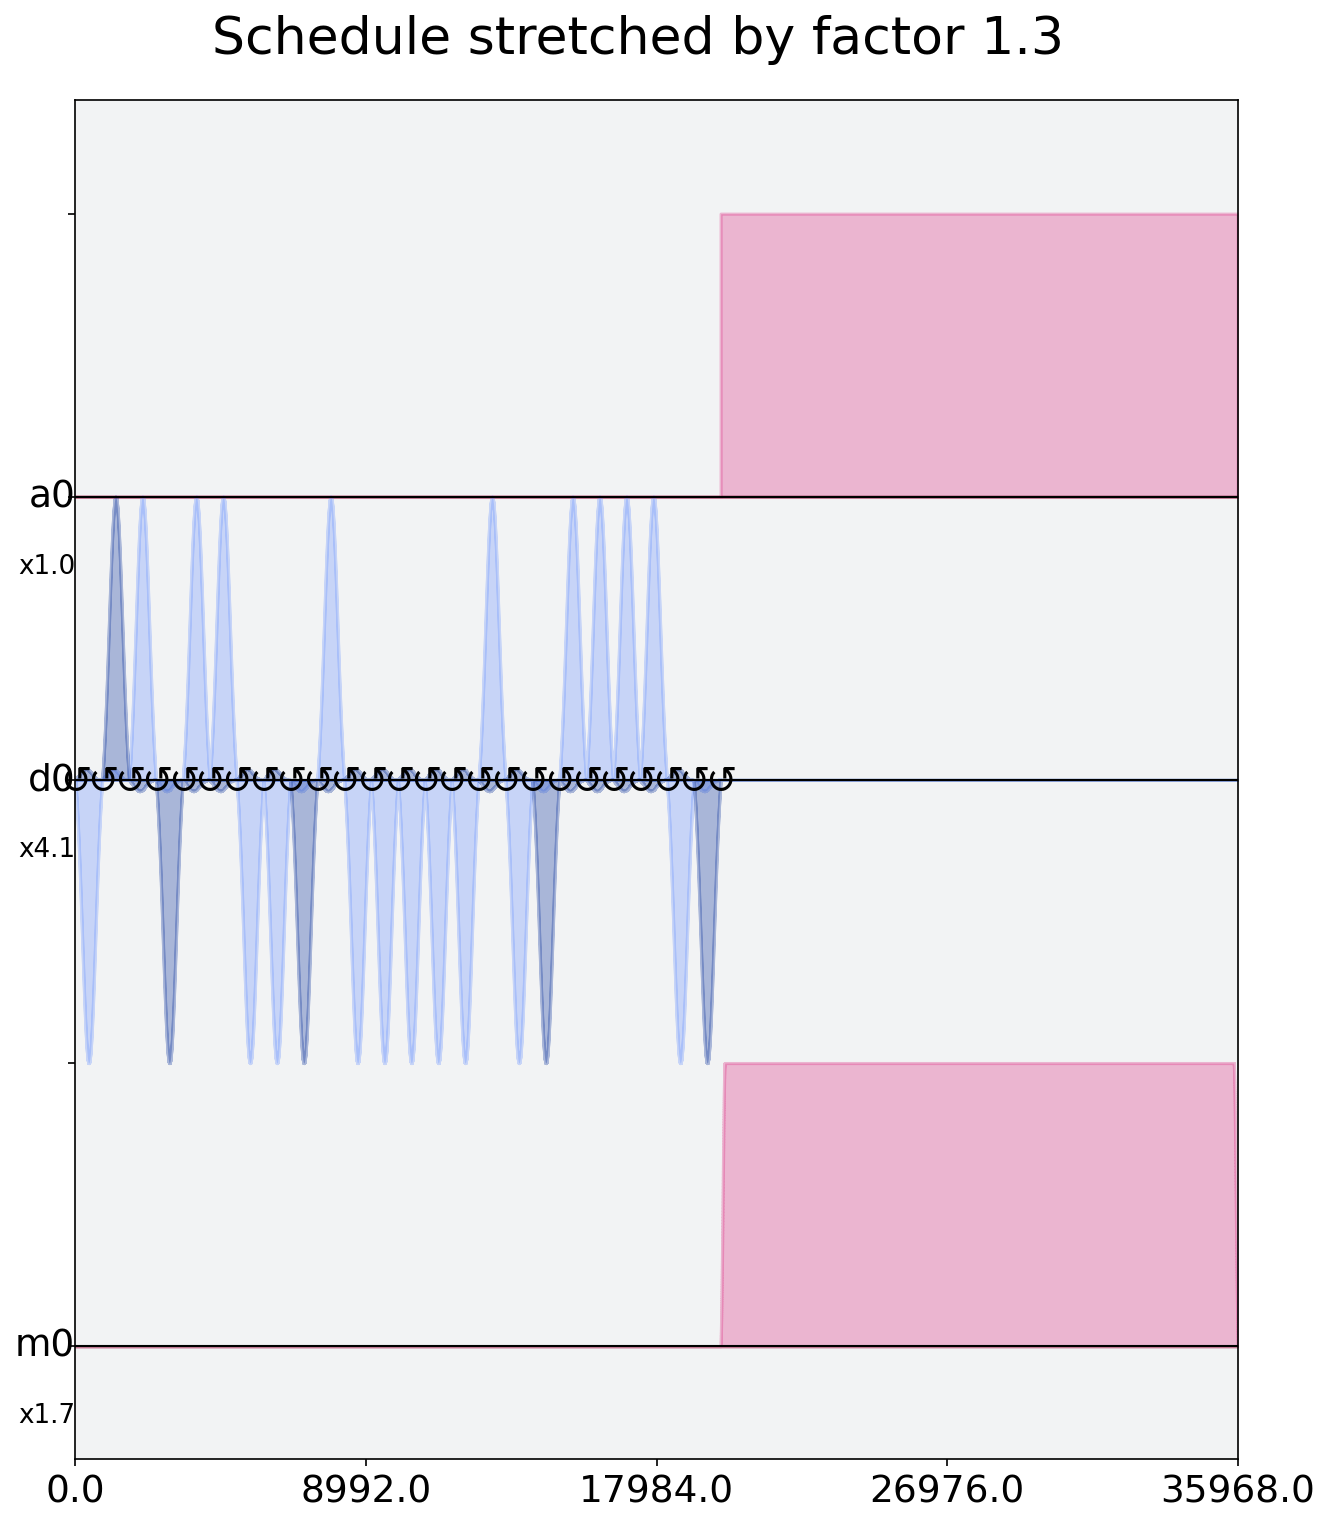

In [13]:
scaled_schedules[3][0][2].draw()

## Running the Schedules

In [14]:
def countsToProb(counts, samples): 
    '''
    Input: counts 
    Output: prob 
    '''
    return (counts['0']/samples)

In [15]:
def averagingSeeds(seeds):
    '''
    Input: list of seed probs - buckets are seeds, each with prob for particular gate length
    Output: a single list of probs of gate lengths (averaging across all seeds)
    '''
    gate_lengths = len(seeds[0])
    n_seeds = len(seeds)
    
    
    result =[] # contain averaged out probs of gate lengths
    
    for i in range(gate_lengths):
        summ = 0
        for j in range(n_seeds): 
            summ += seeds[j][i]
        summ/= n_seeds 
        result.append(summ)
        
    return result

In [16]:
def addDicts(listy): 
    '''
    Input: list of dicts of counts 
    Output: combining all dicts into one dict, returning that
    '''
    keys = ['0', '1']
    master = {}
    
    for key in keys: 
        #initializing master at that key
        master[key] = 0
        
        #now adding up all dictys[key]
        for dicty in listy: 
            try:
                master[key] += dicty[key]
            except KeyError: 
                continue
    return master

In [21]:
def runExperiments(circuits, backend, samples = 8192):
    '''
    Input: List of circuits organized as follows: scales ---> seeds-----> circuits
    Output: List of counts in that same order after executing all circuits at synchronously
    '''
    n_scales = len(circuits)
    n_seeds = len(circuits[0])
    n_gate_lengths = len(circuits[0][0])
    
    #collecting all circuits
    experiments = []
    
    for i in range(n_scales): 
        for j in range(n_seeds):
            for k in range(n_gate_lengths): 
                experiments.append(circuits[i][j][k])
                
    #Executing all experiments
    mod_samples = samples
    master = {'0': 0, '1':0}
    
#Executing all experiments 
    counts = []
    sample_size = samples
    while (sample_size !=0):
        sample_counts = []
        if (sample_size>8192):
            job = execute(experiments, backend, shots=8192)
            job_monitor(job)
            result = job.result()
            sample_counts = result.get_counts()
            sample_size-=8192
        else: 
            job = execute(experiments, backend, shots=sample_size)
            job_monitor(job)
            result = job.result()
            sample_counts = result.get_counts()
            sample_size = 0
        
        if(len(counts)!=0):
            #adding up results of this with all 
            new_counts = []
            for i in range(len(counts)): 
                dicty = addDicts([counts[i], sample_counts[i]])
                new_counts.append(dicty)
            counts = new_counts
        else: 
            counts = sample_counts
    
    
    #Reorganizing counts n
    new_counts = []
    
    for i in range(n_scales): 
        scale_counts = []
        print('--------------------------------------------------New Scale')
        
        for j in range(n_seeds): 
            seed_counts = []
            print('----------------------New Seed')
            
            for k in range(n_gate_lengths): 
                print('-- Gate Length ')
                count  = counts[i*(n_seeds*n_gate_lengths) + j*(n_gate_lengths) + k]
                seed_counts.append(count)
            scale_counts.append(seed_counts)
        new_counts.append(scale_counts)
    
    return new_counts

In [ ]:
#running the jobs 
Probs = [] # buckets are scales, each of which contain probs for various gate lengths 

from qiskit.tools.monitor import job_monitor
Probs = []
samples = 100000

#running all experiments 
counts = runExperiments(scaled_schedules, machine,samples)
print(counts)

for scale_seeds in counts:
    scale_probs = [] # initailly buckets are seeds
    for seed in scale_seeds: 
        seed_probs = []
        for gate_count in seed:
            print(gate_count)
            prob= countsToProb(gate_count, samples)
            seed_probs.append(prob)
        scale_probs.append(seed_probs)
    #averaging probs across all seeds 
    scale_probs = averagingSeeds(scale_probs) #now buckets are gate length prob (bucket are scalar here)
    Probs.append(scale_probs)
    

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job is queued (1)     

## Plotting Results

In [ ]:
import matplotlib.pyplot as plt 


a = plt.figure()
for scale in range(len(Probs)): 
    plt.plot(rb_opts['length_vector'], Probs[scale], marker = 'o', linestyle= '--', label = str(scales[scale]))

plt.title(' Pulse Stretching')
plt.legend()
plt.show()
a.savefig("plotSep30(2).png", dpi = 1000)